# Chapter 9: Unsupervised Learning Techniques

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from tqdm import tqdm
from scipy.stats import loguniform
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.frozen import FrozenEstimator
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin, check_array, check_is_fitted

1. The goal of clustering is to group similar instances together into clusters. One method of doing this is **k-means**, another is a **Gaussian mixture model**.
2. Clustering can be used for image segmentation, semi-supervised learning, customer segmentation, recommender systems, and dimensionality reduction.
3. To select the right *k* in k-means you can:
    * plot the inertia for several values of k and look for an elbow,
    * plot the silhouette score for several values of k and choose the highest one,
    * plot the silhouette coefficients for each instance (the knife plot).
4. **Label propagation** is used for semi-supervised learning. First a clustering algorithm is used to cluster a dataset, then representative instances of each cluster are labelled manually. Finally, the remaining unlabelled instances can be labelled based on what cluster they belong to.
5. Batch k-means and BIRCH are scalable clustering algorithms. DBSCAN & Mean-Shift look for regions of high density.
6. Active learning is useful for when you have limited labelled instances and/or limited labelling capacity. Therefore you want to only manually label instances that will have the most impact on model performance. This can be done through *uncertainty sampling*. A model is trained on a few labelled instances, and then used to make predictions on the unlabelled dataset. The instances for which the model is least confident are labelled manually and the process is repeated.
7. Novelty detection assumes the training dataset is clean (i.e. without anomalies), whereas anomaly detection can be used to find anomalies from within the dataset it is trained on. Some algorithms work best for anomaly detection (e.g., Isolation Forest), while others are better suited for novelty detection (e.g., one-class SVM).
8. A Gaussian mixture model assumes that the dataset is sampled from $k$ Gaussian distributions whose parameters can be estimated via maximum likelihood. It can be used for clustering, anomaly / novelty detection, density estimation.
9. To find the right number of clusters ($k$) for a Gaussian mixture model, you can:
    * plot the *Bayesian information criterion* (**BIC**) or the *Akaike information criterion* (**AIC**) for several GMMs using different values of $k$. The optimal value of $k$ will minimize the BIC & AIC.
    * You can also use a **Bayesian Gaussian Mixture Model**, and set the maximum number of clusters higher than you expect the number of true clusters. The model will set the unnecessary cluster weights to zero automatically.

## 10. Olivetti faces dataset

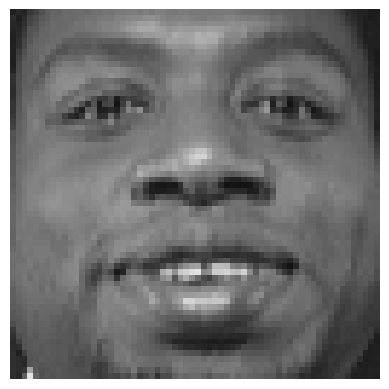

In [2]:
X, y = fetch_olivetti_faces(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=40)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, stratify=y_train, test_size=80
)


def plot_face(face, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.imshow(face.reshape(64, 64), cmap="gray", vmin=0, vmax=1)
    ax.axis("off")


plot_face(X_train[-1])
plt.show()

In [3]:
pca = PCA(n_components=0.99)
pca.fit(X_train)
pca = FrozenEstimator(pca)
print(
    f"Reduced {pca.n_features_in_} dimensions down to {pca.n_components_}, while maintaining {pca.n_components * 100:.0f}% of the variance."
)

models = []
ks = range(5, 200, 5)

for k in tqdm(ks):
    k_means = make_pipeline(pca, KMeans(n_clusters=k, n_init=10))
    k_means.fit(X_train)
    models.append(k_means)

Reduced 4096 dimensions down to 200, while maintaining 99% of the variance.


100%|██████████| 39/39 [00:17<00:00,  2.18it/s]


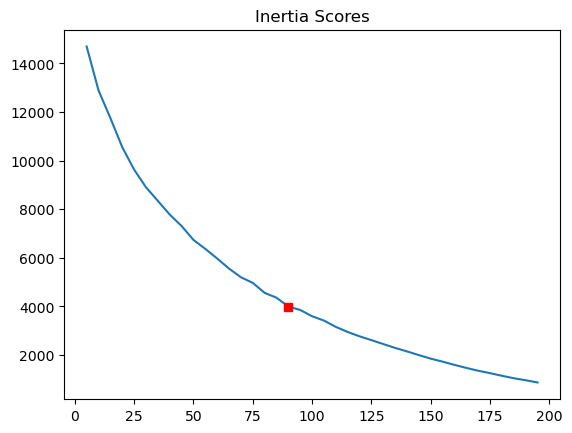

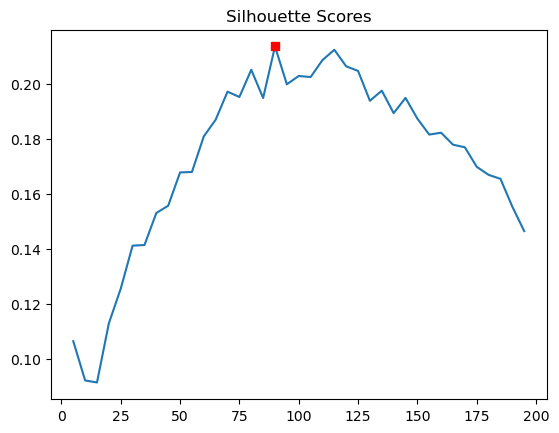

Number of clusters with the highest silhouette score: 90


In [4]:
silhouette_scores = [
    silhouette_score(X_train, model.named_steps.kmeans.labels_) for model in models
]
best_idx = np.argmax(silhouette_scores)
best_k = ks[best_idx]

plt.plot(ks, [model.named_steps.kmeans.inertia_ for model in models])
plt.plot(best_k, models[best_idx].named_steps.kmeans.inertia_, "rs")
plt.title("Inertia Scores")
plt.show()

plt.plot(ks, silhouette_scores)
plt.plot(best_k, silhouette_scores[best_idx], "rs")
plt.title("Silhouette Scores")
plt.show()

print(f"Number of clusters with the highest silhouette score: {best_k}")

In [5]:
k_means.set_params(kmeans__n_clusters=best_k, kmeans__n_init=10)
k_means.fit(X_train)

Pipeline(steps=[('frozenestimator',
                 FrozenEstimator(estimator=PCA(n_components=0.99))),
                ('kmeans', KMeans(n_clusters=90, n_init=10))])

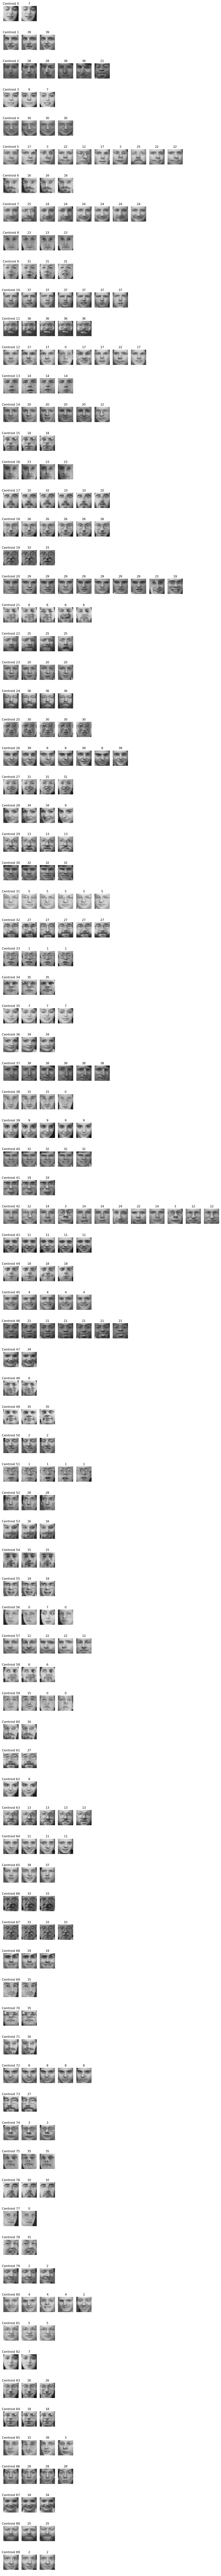

In [6]:
centroids = pca.inverse_transform(k_means.named_steps.kmeans.cluster_centers_)
cluster_faces = [
    X_train[k_means.named_steps.kmeans.labels_ == cluster] for cluster in range(best_k)
]
cluster_faces_labels = [
    y_train[k_means.named_steps.kmeans.labels_ == cluster] for cluster in range(best_k)
]

fig, axs = plt.subplots(
    best_k, max(_.shape[0] for _ in cluster_faces) + 1, figsize=(15, best_k * 2)
)


for cluster in range(best_k):

    plot_face(centroids[cluster], ax=axs[cluster, 0])
    axs[cluster, 0].set_title(f"Centroid {cluster}")

    for i, (face, label) in enumerate(
        zip(
            cluster_faces[cluster],
            cluster_faces_labels[cluster],
        )
    ):
        plot_face(face, ax=axs[cluster, i + 1])
        axs[cluster, i + 1].set_title(label)

for ax in axs.flat:
    ax.axis("off")
plt.show()

## 11. Faces Classifier

In [7]:
svc = RandomizedSearchCV(
    make_pipeline(pca, SVC()),
    {
        "svc__C": loguniform(0.1, 100),
        "svc__gamma": loguniform(0.001, 1),
    },
    n_iter=100,
    verbose=1,
    scoring="accuracy",
    n_jobs=-1,
)

svc.fit(X_train, y_train)

print(
    f"Best parameters: {svc.best_params_}",
    f"Best grid search score: {svc.best_score_}",
    f"Train accuracy: {svc.score(X_train, y_train)}",
    f"Validation accuracy: {svc.score(X_val, y_val)}",
    sep="\n",
)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


Best parameters: {'svc__C': 53.97695288707433, 'svc__gamma': 0.002673522041667201}
Best grid search score: 0.9607142857142857
Train accuracy: 1.0
Validation accuracy: 0.975


In [8]:
classifier = RandomizedSearchCV(
    make_pipeline(pca, KMeans(), SVC()),
    {
        "kmeans__n_clusters": range(80, 150, 5),
        "svc__C": loguniform(1, 100),
        "svc__gamma": loguniform(0.0001, 1),
    },
    n_iter=100,
    verbose=1,
    scoring="accuracy",
    n_jobs=-1,
)

classifier.fit(X_train, y_train)

print(
    f"Best parameters: {classifier.best_params_}",
    f"Best grid search score: {classifier.best_score_}",
    f"Train accuracy: {classifier.score(X_train, y_train)}",
    f"Validation accuracy: {classifier.score(X_val, y_val)}",
    sep="\n",
)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'kmeans__n_clusters': 80, 'svc__C': 51.33277482340259, 'svc__gamma': 0.0005854502857701328}
Best grid search score: 0.8678571428571429
Train accuracy: 0.9964285714285714
Validation accuracy: 0.9125


In [9]:
class KMeansAppend(TransformerMixin, BaseEstimator):

    def __init__(self, n_clusters=8):
        self.n_clusters = n_clusters

    def fit(self, X, y=None):
        X = check_array(X)
        self.n_features_in_ = X.shape[1]

        self.kmeans_ = KMeans(self.n_clusters)
        self.kmeans_.fit(X)

        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)

        return np.hstack((X, self.kmeans_.transform(X)))

In [10]:
classifier = RandomizedSearchCV(
    make_pipeline(pca, KMeansAppend(), SVC()),
    {
        "kmeansappend__n_clusters": range(100, 180, 5),
        "svc__C": loguniform(10, 200),
        "svc__gamma": loguniform(1e-5, 1e-3),
    },
    n_iter=100,
    verbose=1,
    scoring="accuracy",
    n_jobs=-1,
)

classifier.fit(X_train, y_train)

print(
    f"Best parameters: {classifier.best_params_}",
    f"Best grid search score: {classifier.best_score_}",
    f"Train accuracy: {classifier.score(X_train, y_train)}",
    f"Validation accuracy: {classifier.score(X_val, y_val)}",
    sep="\n",
)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'kmeansappend__n_clusters': 140, 'svc__C': 44.28483051249684, 'svc__gamma': 0.00010997838471309489}
Best grid search score: 0.9071428571428573
Train accuracy: 1.0
Validation accuracy: 0.925


## 12. Gaussian Mixture Model on the Olivetti faces dataset

In [11]:
gmm = make_pipeline(pca, GaussianMixture(n_components=best_k))
gmm.fit(X_train)

Pipeline(steps=[('frozenestimator',
                 FrozenEstimator(estimator=PCA(n_components=0.99))),
                ('gaussianmixture', GaussianMixture(n_components=90))])

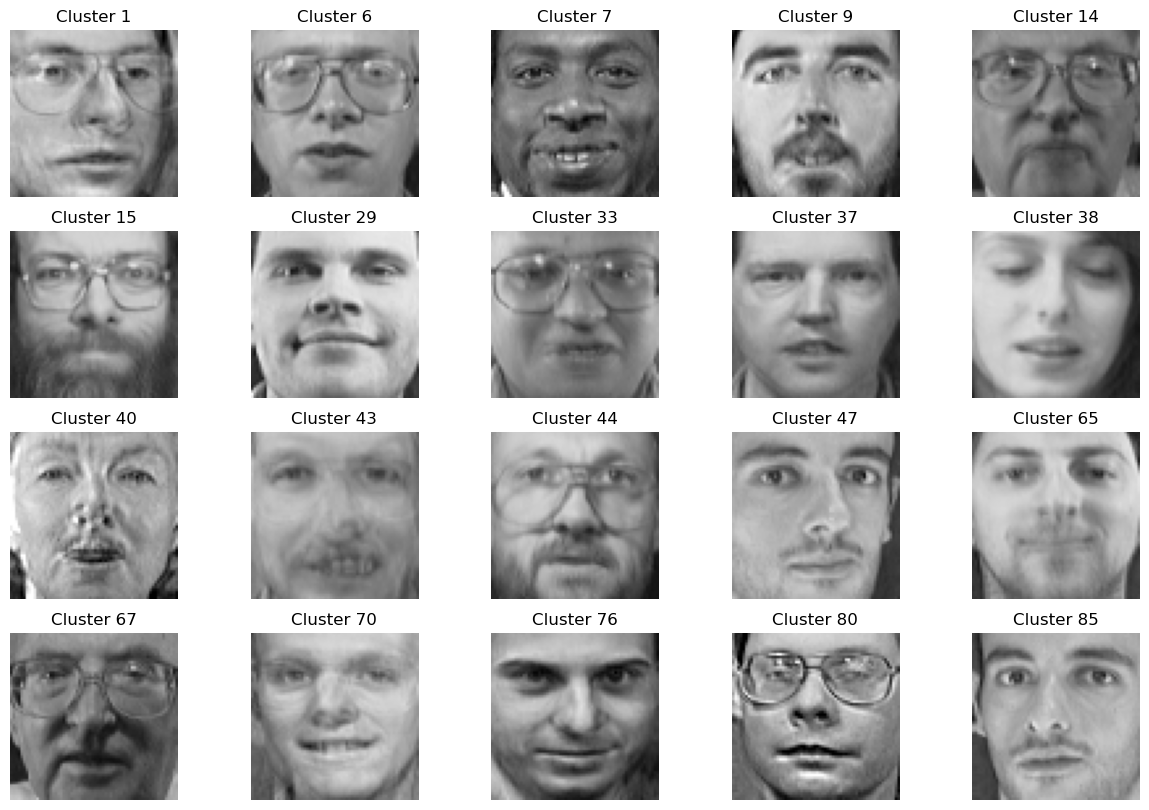

In [12]:
X_generated, y_generated = gmm.named_steps.gaussianmixture.sample(20)
X_generated = pca.inverse_transform(X_generated)

fig, axs = plt.subplots(4, 5, figsize=(15, 10))
for i, (face, label) in enumerate(zip(X_generated, y_generated)):
    plot_face(face, ax=axs[i // 5, i % 5])
    axs[i // 5, i % 5].set_title(f"Cluster {label}")
plt.show()

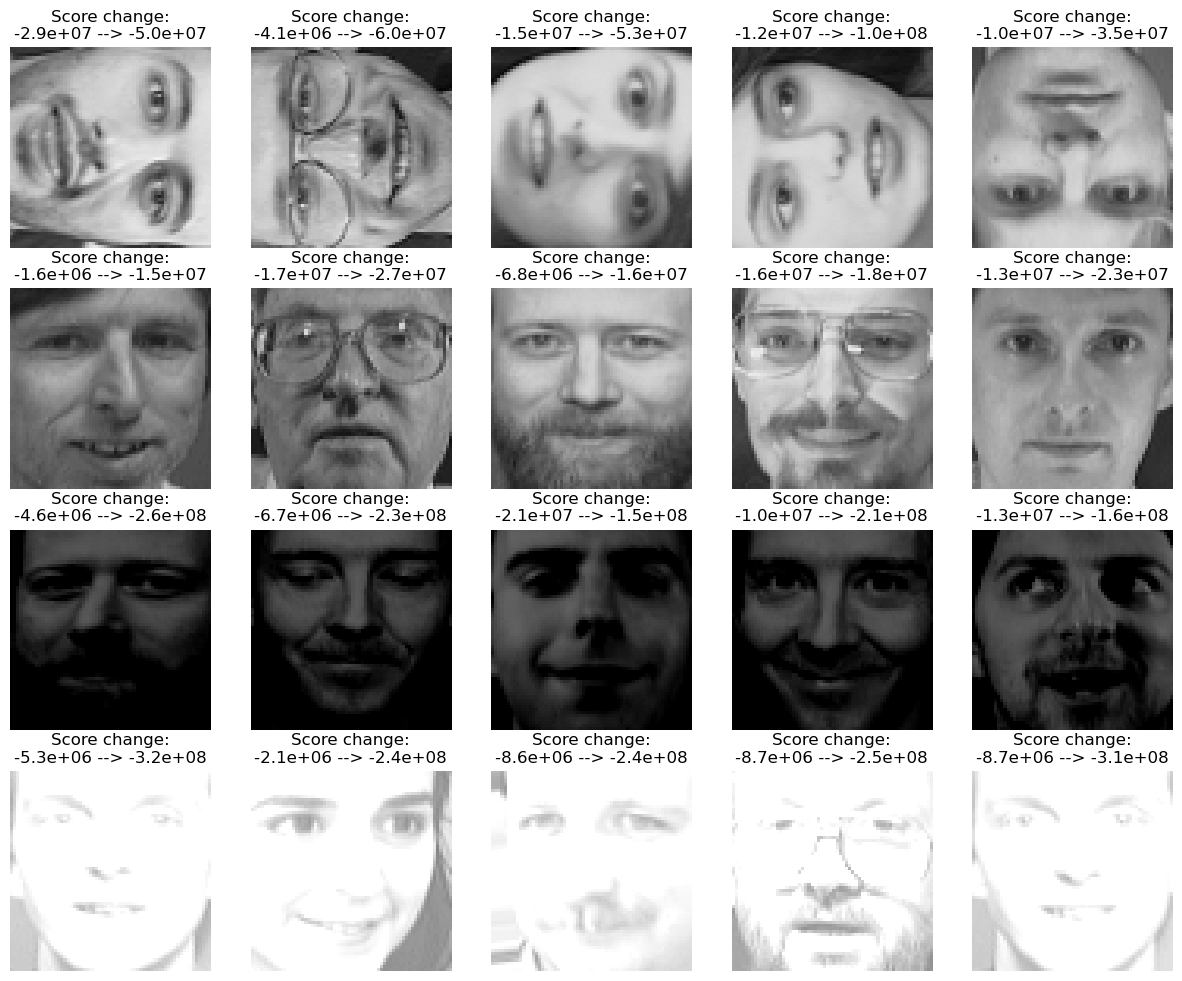

In [13]:
def rotate_face(face):
    return np.rot90(face.reshape(64, 64), k=np.random.randint(1, 4)).ravel()


def flip_face(face):
    return np.rot90(face.reshape(64, 64).T, k=3).ravel()


def darken_face(face):
    return face - 0.5


def lighten_face(face):
    return face + 0.5


X_modified = X_val[:20]
scores = gmm.named_steps.gaussianmixture.score_samples(pca.transform(X_modified))

rotated, flipped, darkened, lightened = [], [], [], []
for i in range(5):
    rotated.append(rotate_face(X_modified[4 * i]))
    flipped.append(flip_face(X_modified[4 * i + 1]))
    darkened.append(darken_face(X_modified[4 * i + 2]))
    lightened.append(lighten_face(X_modified[4 * i + 3]))

X_modified = np.vstack(rotated + flipped + darkened + lightened)
scores_modified = gmm.named_steps.gaussianmixture.score_samples(
    pca.transform(X_modified)
)

fig, axs = plt.subplots(4, 5, figsize=(15, 12))
for i, (face, score, score_modified) in enumerate(
    zip(X_modified, scores, scores_modified)
):
    plot_face(face, ax=axs[i // 5, i % 5])
    axs[i // 5, i % 5].set_title(f"Score change:\n{score:.1e} --> {score_modified:.1e}")
plt.show()

## 13. PCA for anomoly detection

In [14]:
print(
    "Mean reconstruction error on X_val:",
    np.mean(
        np.square(pca.inverse_transform(pca.transform(X_val)) - X_val).mean(axis=-1)
    ),
    sep="\n",
)

Mean reconstruction error on X_val:
0.0020249188


Mean reconstruction error on X_modified:
0.004753995


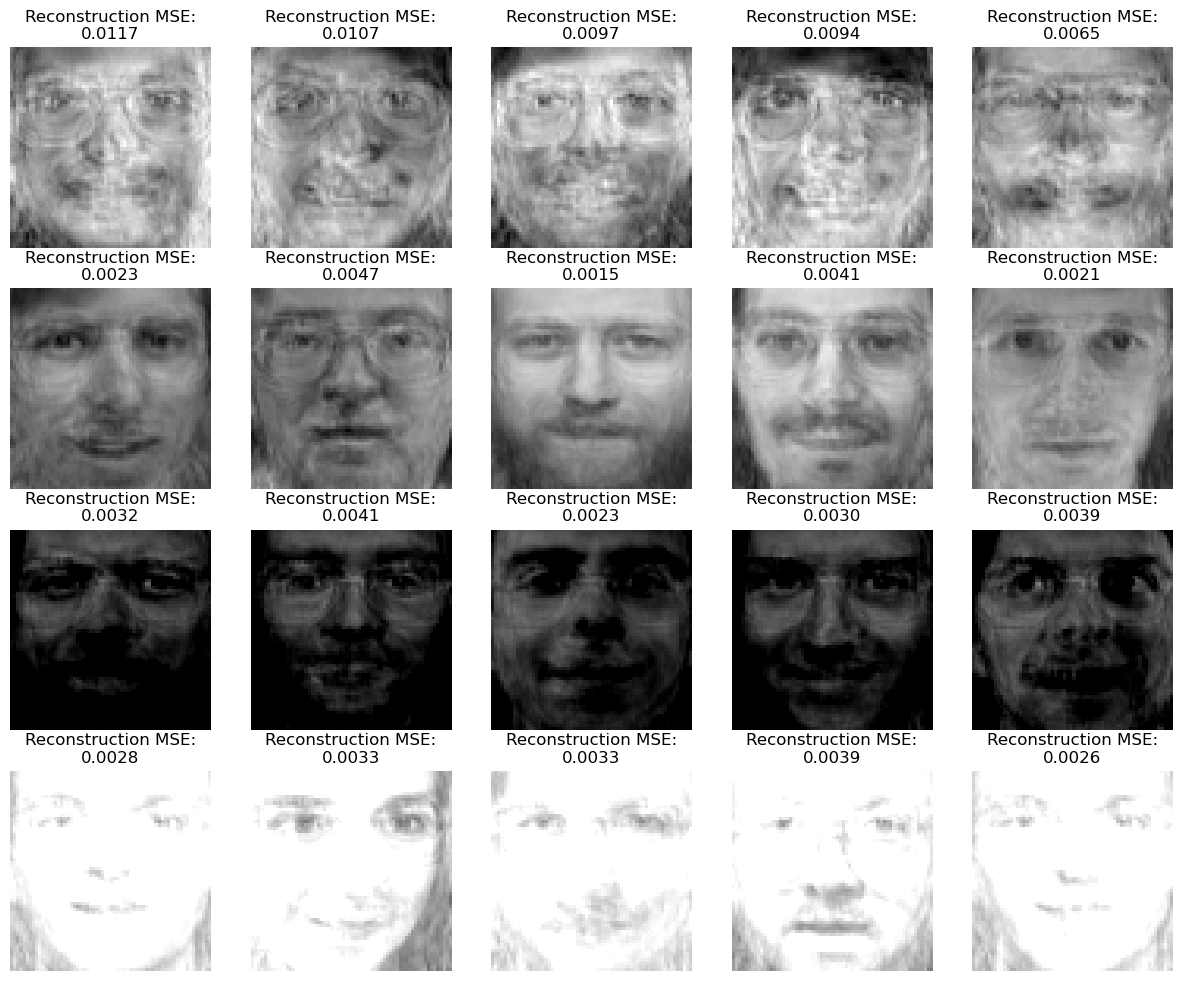

In [15]:
X_modified_reconstructed = pca.inverse_transform(pca.transform(X_modified))
reconstruction_errors = np.square(X_modified_reconstructed - X_modified).mean(axis=-1)
print(
    "Mean reconstruction error on X_modified:",
    np.mean(reconstruction_errors),
    sep="\n",
)

fig, axs = plt.subplots(4, 5, figsize=(15, 12))
for i, (face, reconstruction_error) in enumerate(
    zip(X_modified_reconstructed, reconstruction_errors)
):
    plot_face(face, ax=axs[i // 5, i % 5])
    axs[i // 5, i % 5].set_title(f"Reconstruction MSE:\n{reconstruction_error:.4f}")
plt.show()